In [1]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
dataset = pd.read_csv("/content/drive/MyDrive/ML_Projects/spam_filtering/emails.csv")
dataset.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [4]:
dataset.shape

(5728, 2)

<Axes: xlabel='spam', ylabel='count'>

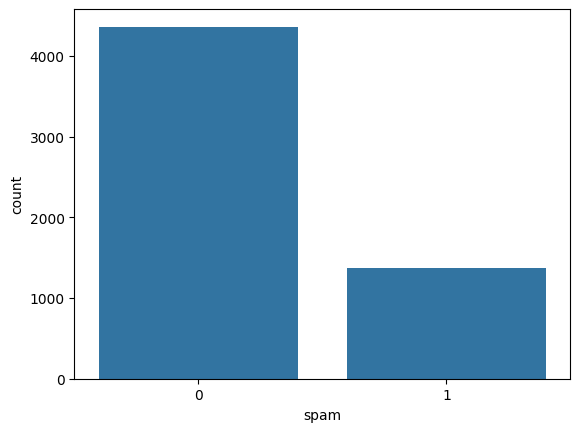

In [5]:
sns.countplot(x="spam", data=dataset)

In [6]:
#Downsampling to balance the dataset
spam_emails = dataset[dataset.spam==1]
ham_emails = dataset[dataset.spam==0]
ham_emails = ham_emails.sample(n=len(spam_emails), random_state=42)
balanced_dataset = pd.concat([spam_emails, ham_emails]).reset_index(drop=True)
balanced_dataset.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


Text(0.5, 1.0, 'Ham and Spam email distribution')

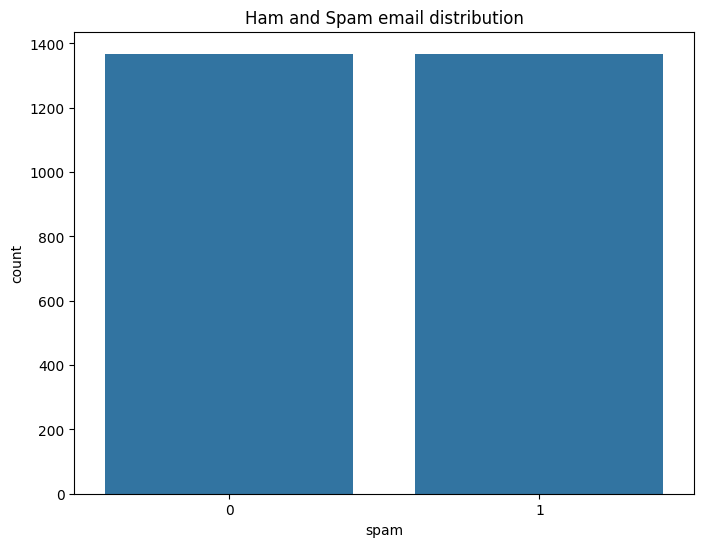

In [7]:
#Plotting the count of down sampled dataset
plt.figure(figsize=(8, 6))
sns.countplot(x="spam", data=balanced_dataset)
plt.title("Ham and Spam email distribution")

# Pre-processing

In [8]:
balanced_dataset["text"] = balanced_dataset["text"].str.replace('Subject', '')
balanced_dataset.head()

,text,spam
0,: naturally irresistible your corporate identi...,1
1,: the stock trading gunslinger fanny is merri...,1
2,: unbelievable new homes made easy im wanting...,1
3,: 4 color printing special request additional...,1
4,": do not have money , get software cds from he...",1


In [9]:
punctuation_list = string.punctuation
punctuation_list

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
def remove_punctuations(text):
  temp = str.maketrans('', '', punctuation_list)
  return text.translate(temp)

balanced_dataset["text"] = balanced_dataset["text"].apply(lambda x: remove_punctuations(x))
balanced_dataset.head()

,text,spam
0,naturally irresistible your corporate identit...,1
1,the stock trading gunslinger fanny is merril...,1
2,unbelievable new homes made easy im wanting ...,1
3,4 color printing special request additional ...,1
4,do not have money get software cds from here...,1


In [11]:
stop_words = stopwords.words('english')
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [12]:
def remove_stopwords(text):
  imp_words = []

  #store important words
  for word in str(text).split():
    word = word.lower()

    if word not in stop_words:
      imp_words.append(word)

  return " ".join(imp_words)

balanced_dataset["text"] = balanced_dataset["text"].apply(lambda x: remove_stopwords(x))
balanced_dataset

,text,spam
0,naturally irresistible corporate identity lt r...,1
1,stock trading gunslinger fanny merrill muzo co...,1
2,unbelievable new homes made easy im wanting sh...,1
3,4 color printing special request additional in...,1
4,money get software cds software compatibility ...,1
...,...,...
2731,powerisk 2000 followup weatherdelta vince cont...,0
2732,rice enron finance seminar series thank vince ...,0
2733,steven roeder chemical engineer vince think ma...,0
2734,vince kaminski expense reports hi liz vince tw...,0


# Word2Vec Conversion

In [13]:
#train test split
train_x, test_x, train_y, test_y = train_test_split(balanced_dataset["text"], balanced_dataset["spam"], test_size=0.2, random_state=42)

In [14]:
train_x

,text
247,please help child dear sir mam send email orde...
2488,subject dear dr kaminski sending attached lett...
2318,thursday visit good morning frank reservations...
347,fwd norton makes best software available 29 99...
1090,investment offer joseph otisa investment offer...
...,...
1638,interview norberto valdes hello norberto telep...
1095,naturally irresistible corporate identity lt r...
1130,med girl happy girl unsatisfied potency wait f...
1294,new penis enlargement patches new penis enlarg...


In [15]:
#Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_x)

In [16]:
#Convert text into sequences
train_sequences = tokenizer.texts_to_sequences(train_x)
test_sequences = tokenizer.texts_to_sequences(test_x)

In [22]:
# padding to have same length
max_length = 100
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post", truncating="post")

# Model Development

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(
    input_dim=len(tokenizer.word_index)+1, output_dim=32, input_length=max_length))

model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
#Callbacks
early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

In [ ]:
#Train the model
history = model.fit(
    train_padded, train_y,
    validation_data=(test_padded, test_y),
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.6283 - loss: 0.6748 - val_accuracy: 0.7737 - val_loss: 0.5681 - learning_rate: 0.0010
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9334 - loss: 0.3151 - val_accuracy: 0.9763 - val_loss: 0.1051 - learning_rate: 0.0010
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9858 - loss: 0.0757 - val_accuracy: 0.9799 - val_loss: 0.0986 - learning_rate: 0.0010
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.9866 - loss: 0.0725 - val_accuracy: 0.9781 - val_loss: 0.1028 - learning_rate: 0.0010


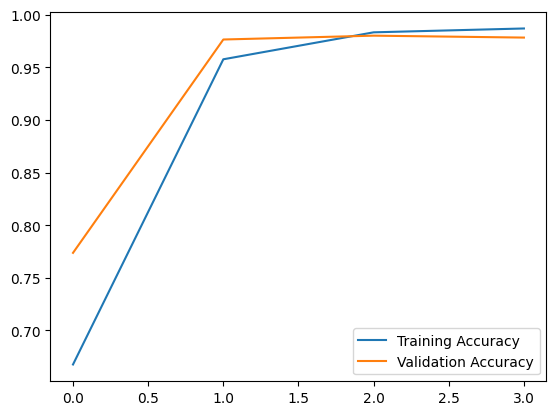

In [ ]:
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
#Evaluation
loss, accuracy = model.evaluate(test_padded, test_y)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9765 - loss: 0.1132
Loss: 0.09856212884187698
Accuracy: 0.9799270033836365
